# RecB dissociation rates under endogenous damage

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',],
                    groups=['0', '0', '0', '0', '0'],
                    filters={'all':'Frame < 50'},
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']


## RecB spots lifetime histogram

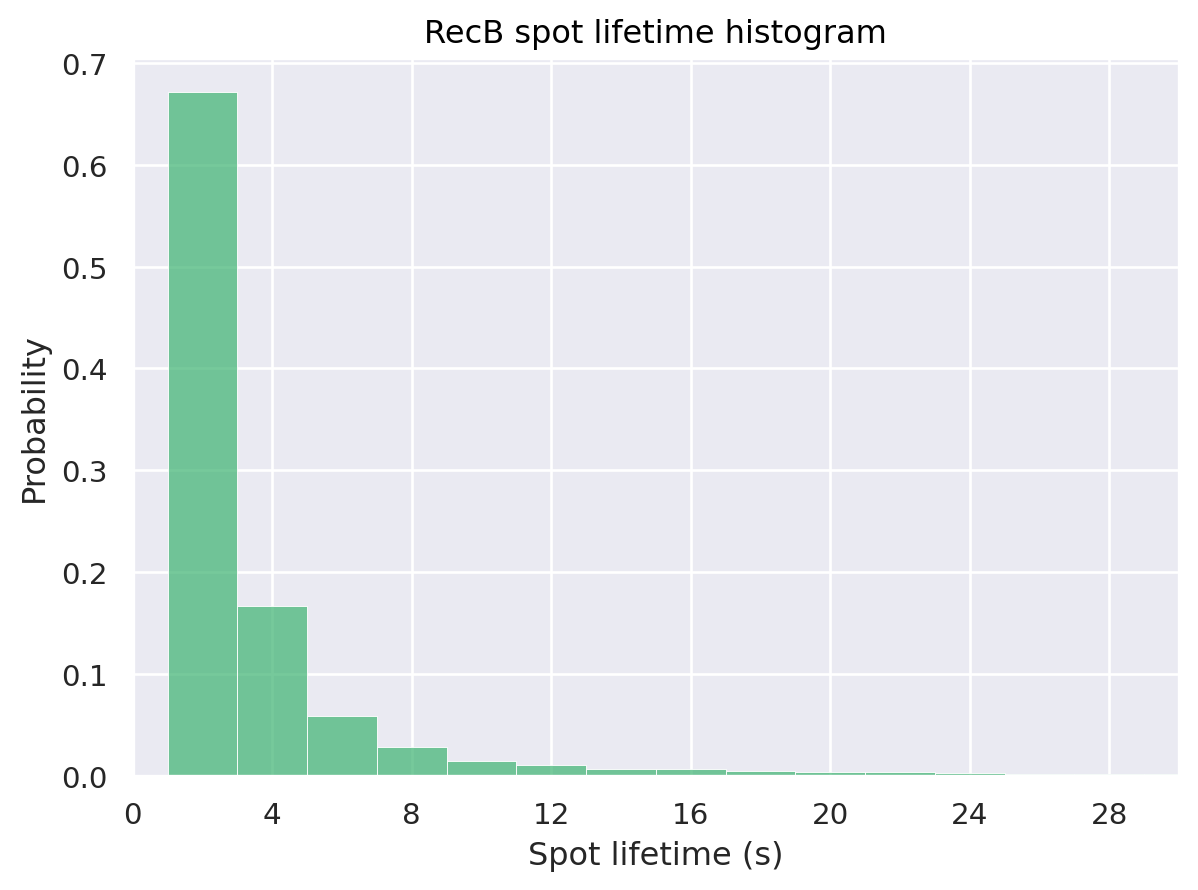

In [2]:
import seaborn.objects as so 
from pyberries.data import get_histogram

data = data.assign(object_name = 'RecB_spots', TrackLength_s=lambda df: df.TrackLength *2)

hist = get_histogram(data.RecB_spots, col='TrackLength_s', binsize=2, density=True, binlabels='left')

(
    so.Plot(hist, x='TrackLength_s', y='proportion')
    .add(so.Bars(color='mediumseagreen'))
    .limit(x=(0, 30))
    .label(x='Spot lifetime (s)', y='Probability', title='RecB spot lifetime histogram')
    .scale(x=so.Continuous().tick(every=4))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/1_Endogenous/Spot_lifetimes.svg', format='svg', bbox_inches='tight')
)

Compute the average and median lifetimes of RecB spots

In [24]:
(data
 .RecB_spots
 .groupby(['Group', 'Dataset'])
 .agg({'TrackLength_s':'mean'})
 .agg({'TrackLength_s':['median', 'mean', 'std']})
 )

,TrackLength_s
median,4.406788
mean,4.485074
std,0.287818


## Bleaching rate fitting

In [3]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset', p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

### Fits plotting

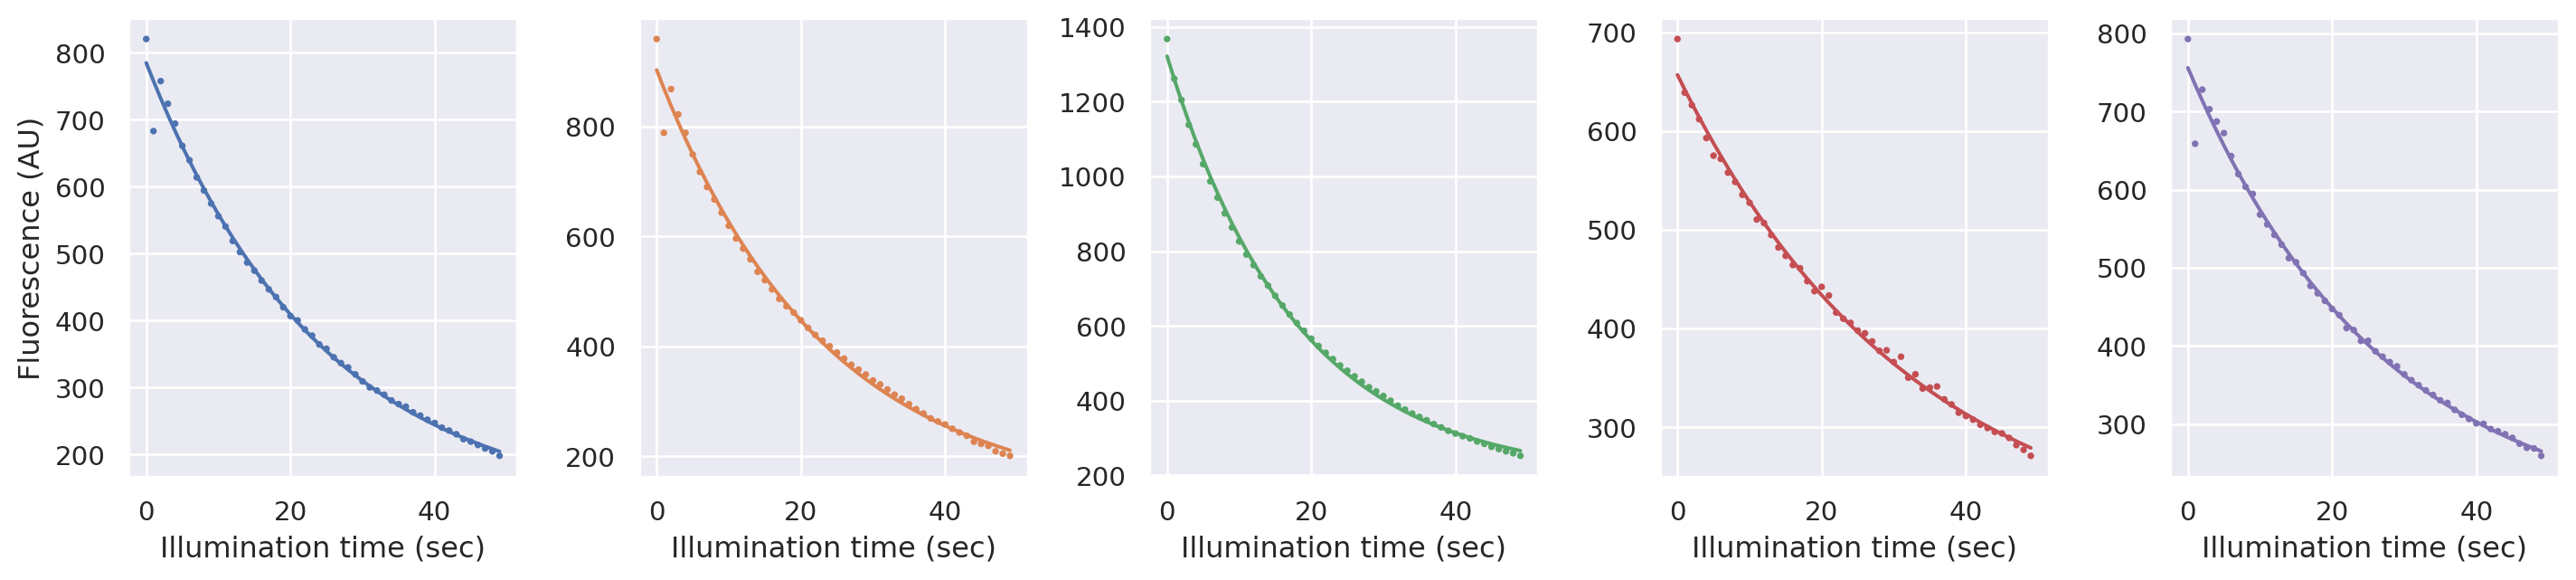

In [4]:
import seaborn.objects as so

(
    so.Plot(bleaching_fit.data, x='Frame', color='Dataset')
    .layout(size=(15, 3.5))
    .facet(col='Dataset', wrap=5)
    .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR', legend=False)
    .add(so.Line(linestyle='-'), y='Fit', legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
)

### Percentage of initial fluorescence remaining at the end of the acquisition

In [4]:
import pandas as pd

df = (bleaching_fit
      .data
      .query('Frame == 0 or Frame == 49')
      .pipe(lambda df: pd.pivot_table(df, values='SNR', index=['Dataset'], columns='Frame'))
      .reset_index()
      .assign(remaining_fluo=lambda df: df[49] / df[0] *100)
      )

display(df)

print(f'Average remaining fluorescence = {df.remaining_fluo.mean():.0f}% +/- {df.remaining_fluo.std():.0f}')

Frame,Dataset,0,49,remaining_fluo
0,230126_DT23,1367.582335,252.424668,18.457731
1,230719_1,693.177493,270.950936,39.088248
2,230719_2,792.823000,259.373738,32.715214
3,230725_1,820.633980,197.703789,24.091592
4,230725_2,958.870787,201.193405,20.982327


Average remaining fluorescence = 27% +/- 9


### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

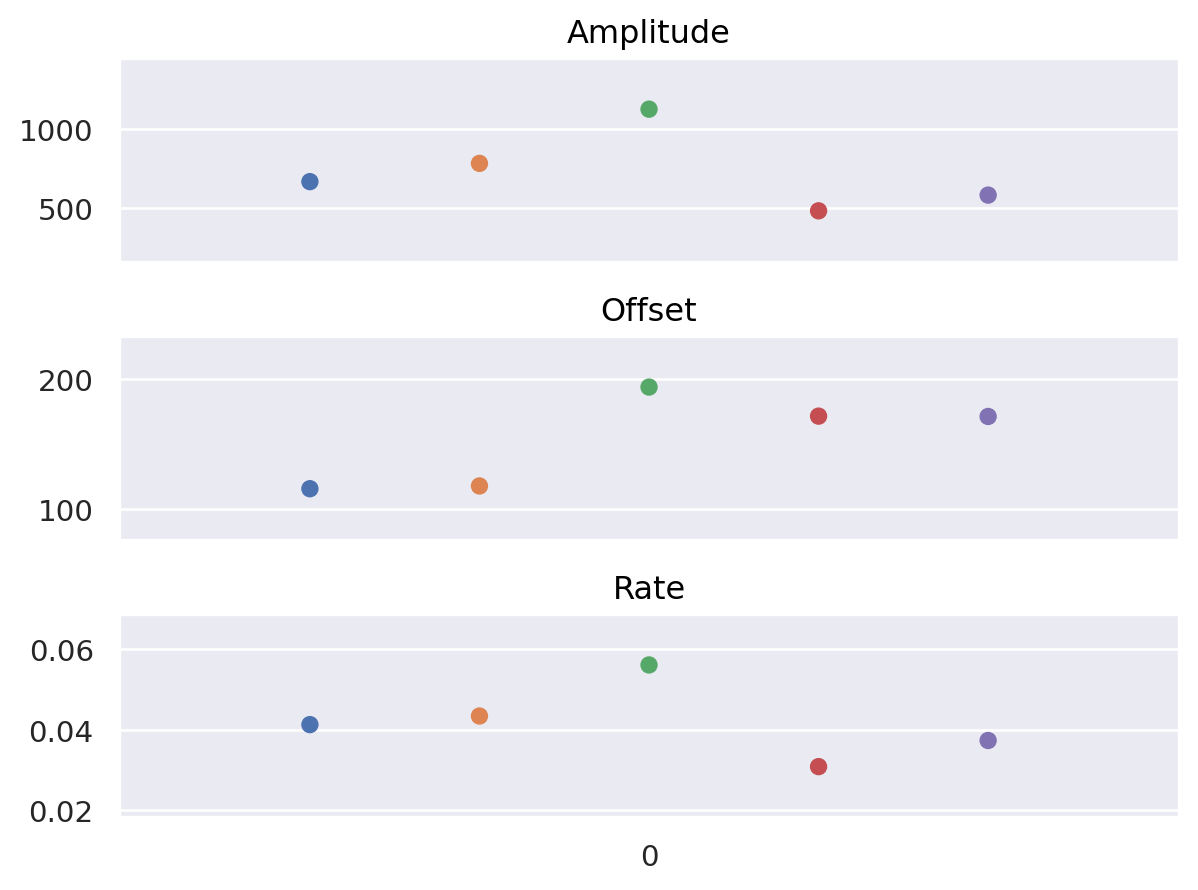

In [5]:
import seaborn.objects as so

bleaching_parameters = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])

(
    so.Plot(bleaching_parameters, x='Group', y='Fitted_param', color='Dataset')
    .facet(row='Param_name')
    .add(so.Dot(), so.Dodge(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

### Adjust bleahcing rates to frame time

The rate fitted above is a rate "per frame". Divide it by the frame interval (sec) to obtain the bleaching rate per second (adjusted rate).

In [6]:
bleaching_rates = (bleaching_parameters
                   .query('Param_name == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Fitted_param.div(2))
                   )

display(bleaching_rates)

,Group,Fitted_param,Param_name,Dataset,Adjusted_rate
1,0,0.041263,Rate,230725_1,0.020632
4,0,0.043411,Rate,230725_2,0.021705
7,0,0.056136,Rate,230126_DT23,0.028068
10,0,0.030790,Rate,230719_1,0.015395
13,0,0.037309,Rate,230719_2,0.018654


## RecB spot lifetime fit

### A monoexponential decay does not fit the histograms

In [13]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'], density=True, binlabels='left')
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 1])

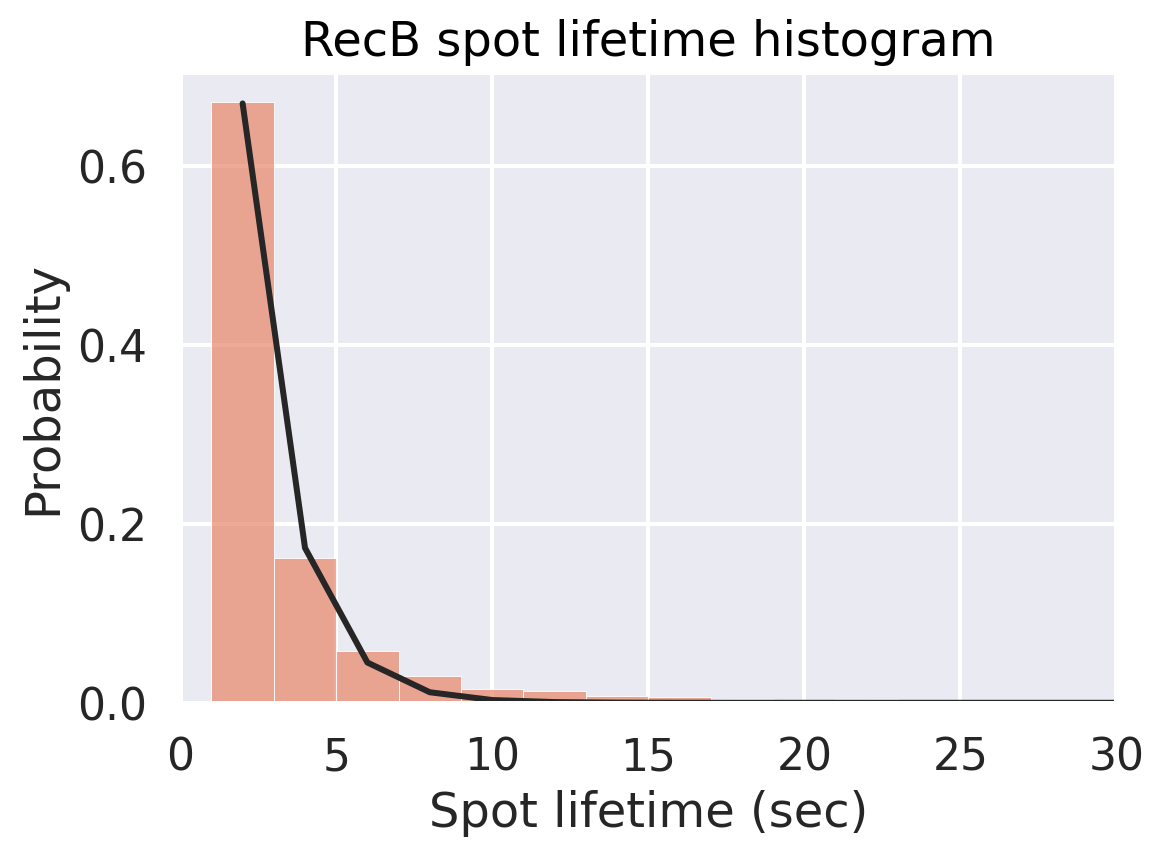

In [14]:
import seaborn.objects as so
import seaborn as sns

df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength *2)
      )

color = sns.color_palette('flare', 5)[0]

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color=color), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .theme(sns.plotting_context('talk'))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='RecB spot lifetime histogram')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/1_Endogenous/Fit_monoexp.svg', format='svg', bbox_inches='tight')
)

In [38]:
import pandas as pd
import numpy as np

display(monoexp_fit
        .get_fit_parameters(param_names=['Amplitude', 'Rate'])
        .pipe(lambda df: pd.pivot_table(df, values='Fitted_param', index=['Dataset'], columns=['Param_name']))
        .assign(Lifetime=lambda df: 1/df.Rate *2)
        .agg({'Lifetime':['mean', 'std']})
        )

Param_name,Lifetime
mean,1.480107
std,0.097119


#### Log-likelihood test for nested models

TO BE REMOVED, keeping this here as a reference for potential use in the cipro section.

This uses the log-likelihood value and Chi-squared distribution to produce a p-value.

p < 0.05 means that the bi-exponential model fits the data better than the mono-exponential model.

In [6]:
from scipy.stats import chi2

for grp in monoexp_fit.llf.keys():
    LR_statistic = -2*(monoexp_fit.llf[grp] - biexp_fit.llf[grp])
    p_val = chi2.sf(LR_statistic, 2)
    print(f'{grp}: p-value = {p_val}')

230725_1--0: p-value = 6.027160598881866e-23
230725_2--1: p-value = 5.262442604426232e-28
230126_DT23--2: p-value = 2.8237160826579765e-20
230719_1--3: p-value = 8.786190579206016e-10
230719_2--4: p-value = 1.3228288949988035e-21
